In [1]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from scipy import optimize

In [25]:
#from Laher & Gilmore (1991)
states_N2 = ["N2(X1Sigmag+)","N2(A3Sigmau+)","N2(B3Pig)","N2(W3Deltau)","N2(Bp3Sigmau-)",
             "N2(ap1Sigmau-)","N2(a1Pig)","N2(w1Deltau)","N2(C3Piu)","N2(E3Sigmag+)","N2(D3Sigmau+)"]
states_N2p = ["N2+(X2Sigmag+)","N2+(A2Piu)","N2+(B2Sigmau+)","N2+(C2Sigmau+)"]

"vibrational constants: starting at X1Sigmag+: T0, we, wexe, weye, weze, weae"
vib_constants_N2 = [[0.0, 2358.57, 14.324, -2.26E-3, -2.4E-4, 0],
                    [49754.8, 1460.48, 13.775, -1.175E-2, 1.41E-4, -7.29E-5],
                    [59306.8, 1734.38, 14.558, 1.40E-2, -1.13E-3, 0],
                    [59380.2, 1506.53, 12.575, 3.09E-2, -7.1E-4, 0],
                    [65851.3, 1516.88, 12.181, 4.19E-2, -7.3E-4, 0],
                    [67739.3, 1530.25, 12.075, 4.13E-2, -2.9E-4, 0],
                    [68951.2, 1694.21, 13.949, 7.94E-3, 2.9E-4, 0],
                    [71698.4, 1559.50, 12.008, 4.54E-2, 0, 0],
                    [88977.9, 2047.18, 28.445, 2.0883, -5.350E-1, 0],
                    [95774.5, 2218, 16.3, -2.7E-2, -2.6E-3, 0],
                    [103570.9, 2207, 16.3, -2.7E-2, -2.6E-3, 0]]

"vibrational constants: starting at X2Sigmag+: T0, we, wexe, weye, weze, weae"
vib_constants_N2p = [[125667.5, 2207.37, 16.302, -2.67E-3, -2.61E-3, 3.7E-5],
                     [134683.1, 1903.51, 15.029, 2.03E-3, 0, 0],
                     [151233.5, 2420.83, 23.851, -0.3587, -6.192E-2, 0],
                     [190209.5, 2071.5, 9.29, -0.43, 0, 0]]

"rotational constants: starting at X1Sigmag+: Be, alphae, gammae, deltae, epsilone"
rot_constants_N2 = [[1.99824, 1.7318E-2, -3.3E-5, 0, 0],
                    [1.45499, 1.8385E-2, 1.24E-5, -6.7E-6, 0],
                    [1.63802, 1.8302E-2, -8.4E-6, -3.4E-6, 0],
                    [1.47021, 1.6997E-2, -1.01E-5, 3.3E-7, 0],
                    [1.4731, 1.668E-2, 1.84E-5, -4.5E-7, 0],
                    [1.4799, 1.657E-2, 2.41E-5, 0, 0],
                    [1.6169, 1.793E-2, -2.93E-5, 0, 0],
                    [1.4963, 1.63E-2, 0, 0, 0],
                    [1.8247, 1.868E-2, -2.28E-3, 7.33E-4, -1.5E-4],
                    [1.9368, 1.90E-2, -1.9E-4, 0, 0],
                    [1.9705, 1.90E-2, -1.9E-4, 0, 0]]

"rotational constants: starting at X2Sigmag+: Be, alphae, gammae, deltae, epsilone"
rot_constants_N2p = [[1.93177, 1.900E-2, -1.91E-5, -5.00E-6, 4.6E-8],
                     [1.7442, 1.838E-2, -1.76E-4, 4.4E-6, 0],
                     [2.0845, 2.132E-2, -8.5E-4, 0, 0],
                     [1.5114, 1.10E-3, -8.2E-4, 0, 0]]

In [3]:
mu=1.16294E-26 # N2 reduced mass
wavenumber_per_eV = 8065.6

In [4]:
def Gv(v, we, wexe, weye, weze=0, weae=0):
    "Vibrational energy level"
    return we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3 + weze*(v+1/2)**4 + weae*(v+1/2)**5

def Te(v, T0, we, wexe, weye, weze=0, weae=0):
    "Energy at minimum of well"
    return T0 - we/2 + wexe/4 - weye/8 - weze/16 - weae/32

def Tv(v, T0, we, wexe, weye, weze=0, weae=0):
    "Energy difference from minimum to vibrational energy level"
    return Te(v, T0, we, wexe, weye, weze, weae) + Gv(v, we, wexe, weye, weze, weae)

def Bv(v, Be, ae, ge=0, de=0, ee=0):
    "Rotational energy level"
    return Be - ae*(v+1/2) - ge*(v+1/2)**2 + de*(v+1/2)**3 + ee*(v+1/2)**4

def fIntegrand(vp, v, vibConstants):
    "Integrand of Gilmore et al (1992) eqn 1"
    (T0, we, wexe, weye, weze, weae) = vibConstants
    return 1/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

def gIntegrand(vp, v, vibConstants, rotConstants):
    "Integrand of Gilmore et al (1992) eqn 2"
    (T0, we, wexe, weye, weze, weae) = vibConstants
    (Be, ae, ge, de, ee) = rotConstants
    return Bv(v,Be,ae,ge)/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

In [5]:
def f(v, vibConstants):
    "Gilmore et al (1992) eqn 1"
    I = quad(fIntegrand,-1/2,v,args=(v, vibConstants), full_output=True, epsabs=1.0E-16, limit=24)
    return 1/(2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck)) * I[0] * 1E8

def g(v, vibConstants, rotConstants):
    "Gilmore et al (1992) eqn 2"
    I = quad(gIntegrand,-1/2,v,args=(v, vibConstants, rotConstants), epsabs=1.0E-16, limit=24)
    return 2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck) * I[0] * 1E-8

In [6]:
def r(v, vibConstants, rotConstants):
    "Compute r_inner and r_outer from Gilmore et al (1992) eqn 3"
    fv=f(v, vibConstants)
    gv=g(v, vibConstants, rotConstants)
    return [math.sqrt(fv**2 + fv/gv)-fv, math.sqrt(fv**2 + fv/gv)+fv]

In [49]:
def compute_pes(state, vib_constants, rot_constants, vmax=3):
    """compute vmax*2 points on a potential energy surface defined by
    vibrational constants (vib_constants) and rotational constants (rot_constants)
    for state 'state'
    
    Arguments
    ---------
    state : int
        the array index of the vib_contants and rot_contants arrays indicating
        which state is to be computed
        
    vib_/rot_constants : list
        list of vibrational and rotational constants from constants.py
        
    vmax : int
        max vibrational mode of interest; vmax * 2 points will be calculated
        (r_inner's and r_outer's)
        
    Returns
    -------
    pes : numpy.array
        points on the PES (r, Tv)
    """
    pes = []
    
    # had to add in the vib_constants_N2 for it to pull the right state out
    # initially it was just vib_constants[state]
    (T0, we, wexe, weye, weze, weae) = vib_constants_N2[state]
    
    # had to add in the rot_constants_N2 for it to pull the right state out
    # initially it was just rot_constants[state]
    for vp in range(vmax+1):
        rvp=r(vp, vib_constants[state], rot_constants_N2[state])
        Tvp=Tv(vp, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        pes.insert(0, [rvp[0], Tvp])
        pes.append([rvp[1], Tvp])
    
    pes = np.asarray(pes)
                
    return pes

In [50]:
vib_constants_N2[2]

[59306.8, 1734.38, 14.558, 0.014, -0.00113, 0]

In [67]:
"""
# the number of vibrational modes
vibrational_mode = np.arange(5, 25)

# dictionary for the mean square errors of the different vibrational modes
msqe_X1Sigmagp = {}
msqe_A3Sigmaup = {}
msqe_B3Pig = {}

# dictionary for the constants we'll get from the fit
fit_constants_X1 = {}
fit_constants_A3 = {}
fit_constants_B3 = {}

for i in vibrational_mode:
    
    X1Sigmagp_pes = compute_pes(0, vib_constants_N2, rot_constants_N2, vmax=i)
    A3Sigmaup_pes = compute_pes(1, vib_constants_N2, rot_constants_N2, vmax=i)
    B3Pig_pes = compute_pes(2, vib_constants_N2, rot_constants_N2, vmax=i)

    # optimize has a hard time doing the fit with a square in the function. You have to decompose it. 
    # Also, you have to give it a constant (p[2]) for the minimum energy when r=r_e.

    fitfunc = lambda p, x: p[0] * (1.0 - np.exp(-p[1] * (x - p[2]))) * (1.0 - np.exp(-p[1] * (x - p[2]))) + p[3] # Target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

    # p[0]=De, p[1]=Beta, p[2]=re, p[3]=D0 
    p0_0 = [10.0, 0.001, 0.11, -1.0] # Initial guess for the parameters
    p0_1, success0 = optimize.leastsq(errfunc, p0_0[:], args=(X1Sigmagp_pes[:,0], X1Sigmagp_pes[:,1]))

    # p[0]=De, p[1]=Beta, p[2]=re, p[3]=D0 
    p1_0 = [10.0, .001, 0.13, 6.0] # Initial guess for the parameters
    p1_1, success1 = optimize.leastsq(errfunc, p1_0[:], args=(A3Sigmaup_pes[:,0], A3Sigmaup_pes[:,1]))
    
    p2_0 = [10.0, .001, 0.13, 6.0] # Initial guess for the parameters
    p2_1, success1 = optimize.leastsq(errfunc, p2_0[:], args=(B3Pig_pes[:,0], B3Pig_pes[:,1]))
    
    # constants taken from the fit: De, Beta, re, D0
    fit_constants_X1[i] = [p0_1[0], p0_1[1], p0_1[2], p0_1[3]]
    fit_constants_A3[i] = [p1_1[0], p1_1[1], p1_1[2], p1_1[3]]
    fit_constants_B3[i] = [p2_1[0], p2_1[1], p2_1[2], p2_1[3]]
    
    # Plotting the functions
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    # plotting X1Sigmagp
    x,y = X1Sigmagp_pes.T
    x_fit_X1 = np.insert(x, i+1, p0_1[2])
    y_fit_X1_nore = fitfunc(p0_1, x)
    y_fit_X1 = fitfunc(p0_1, x_fit_X1)

    plt.plot(x, y, "ro", label = 'X${}^1\;\Sigma_g^\prime$ PES')
    plt.plot(x_fit_X1, y_fit_X1, "g-", label = 'X${}^1\;\Sigma_g^\prime$ Morse') # Plot of the data and the fit

    # plotting A3Sigmaup
    x,y = A3Sigmaup_pes.T
    x_fit_A3 = np.insert(x, i+1, p1_1[2])
    y_fit_A3_nore = fitfunc(p1_1, x) # the fit function without the re value so that we can do the msqe
    y_fit_A3 = fitfunc(p1_1, x_fit_A3)

    plt.plot(x, y, "bo", label = 'A${}^3\;\Sigma_u^\prime$ PES')
    plt.plot(x_fit_A3, y_fit_A3, "y-", label = 'A${}^3\;\Sigma_u^\prime$ Morse') # Plot of the data and the fit
    
    # plotting B3Pig
    x,y = B3Pig_pes.T
    x_fit_B3 = np.insert(x, i+1, p2_1[2])
    y_fit_B3_nore = fitfunc(p2_1, x) # the fit function without the re value so that we can do the msqe
    y_fit_B3 = fitfunc(p2_1, x_fit_A3)

    plt.plot(x, y, "go", label = 'B${}^3\;\Pi_g^\prime$ PES')
    plt.plot(x_fit_B3, y_fit_B3, "y-", label = 'B${}^3\;\Pi_g^\prime$ Morse')
    
    # extra plot things
    plt.title('Vibrational Mode: %s' % i)
    plt.legend(loc='lower right');
    plt.show()

    # calculating the mean square error of between the PES and the fit 
    msqe_X1Sigmagp_cal = (np.square(X1Sigmagp_pes.T[1] - y_fit_X1_nore)).mean()
    msqe_X1Sigmagp[i] = msqe_X1Sigmagp_cal

    # calculating the mean square error of between the PES and the fit
    msqe_A3Sigmaup_cal = (np.square(A3Sigmaup_pes.T[1] - y_fit_A3_nore)).mean()
    msqe_A3Sigmaup[i] = msqe_A3Sigmaup_cal
    
    msqe_B3Pig_cal = (np.square(B3Pig_pes.T[1] - y_fit_B3_nore)).mean()
    msqe_B3Pig[i] = msqe_B3Pig_cal
    """

'\n# the number of vibrational modes\nvibrational_mode = np.arange(5, 25)\n\n# dictionary for the mean square errors of the different vibrational modes\nmsqe_X1Sigmagp = {}\nmsqe_A3Sigmaup = {}\nmsqe_B3Pig = {}\n\n# dictionary for the constants we\'ll get from the fit\nfit_constants_X1 = {}\nfit_constants_A3 = {}\nfit_constants_B3 = {}\n\nfor i in vibrational_mode:\n    \n    X1Sigmagp_pes = compute_pes(0, vib_constants_N2, rot_constants_N2, vmax=i)\n    A3Sigmaup_pes = compute_pes(1, vib_constants_N2, rot_constants_N2, vmax=i)\n    B3Pig_pes = compute_pes(2, vib_constants_N2, rot_constants_N2, vmax=i)\n\n    # optimize has a hard time doing the fit with a square in the function. You have to decompose it. \n    # Also, you have to give it a constant (p[2]) for the minimum energy when r=r_e.\n\n    fitfunc = lambda p, x: p[0] * (1.0 - np.exp(-p[1] * (x - p[2]))) * (1.0 - np.exp(-p[1] * (x - p[2]))) + p[3] # Target function\n    errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to t

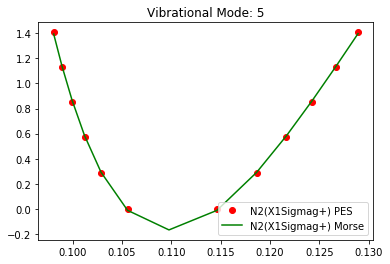

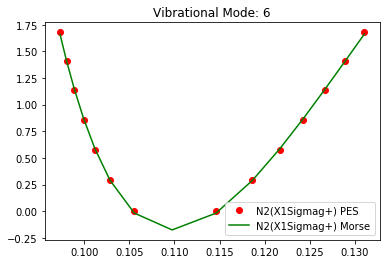

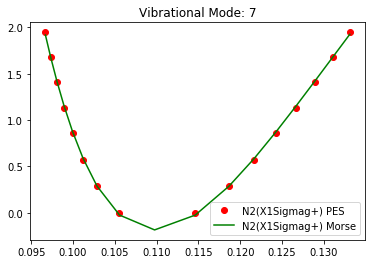

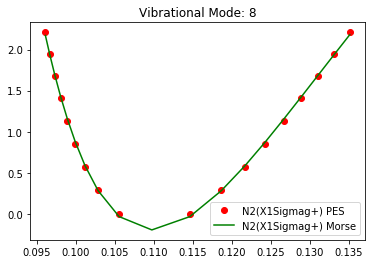

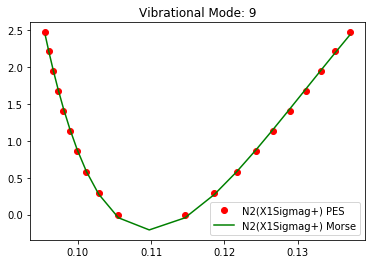

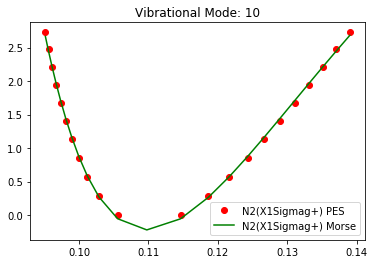

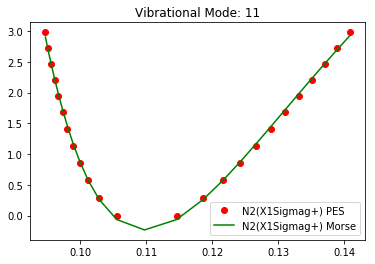

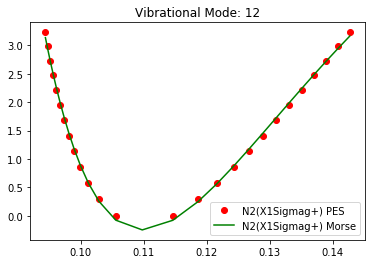

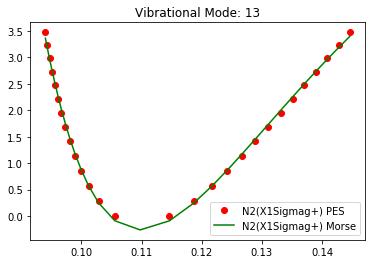

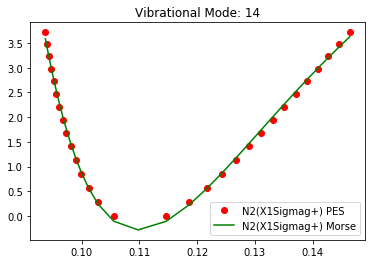

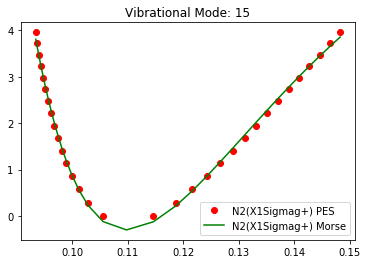

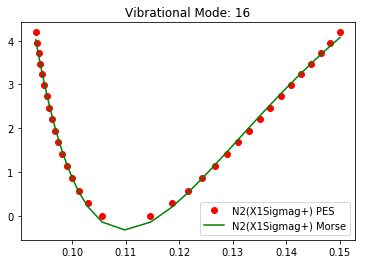

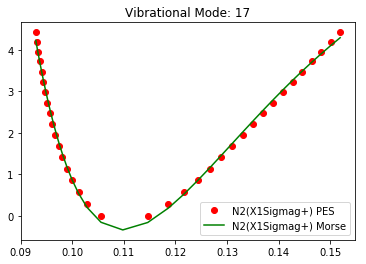

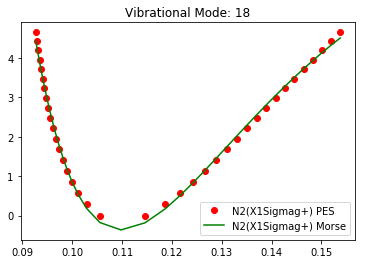

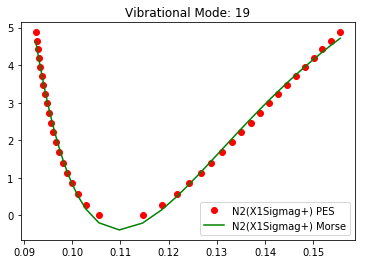

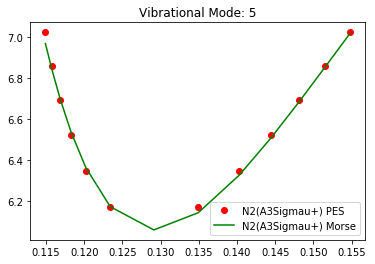

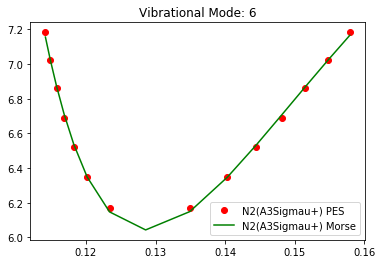

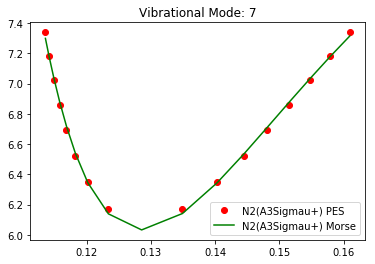

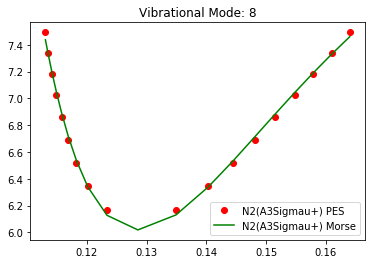

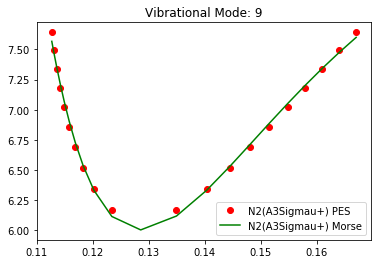

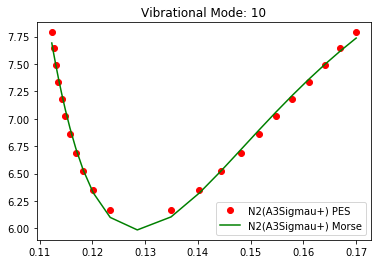

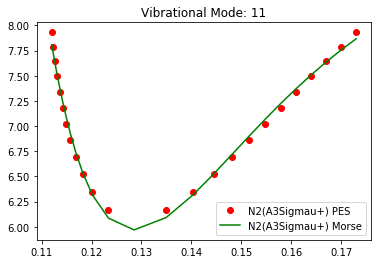

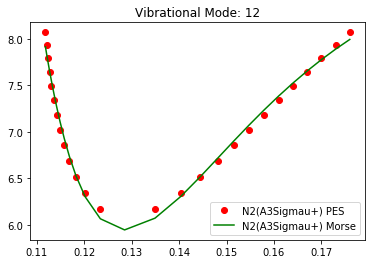

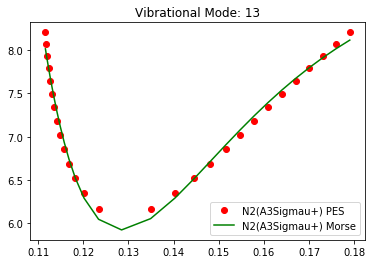

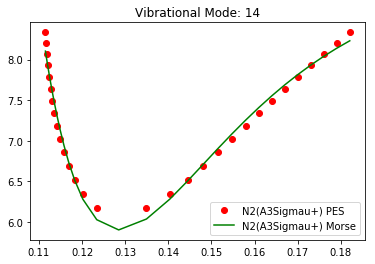

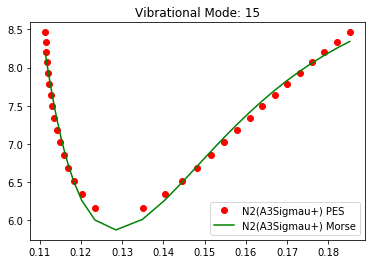

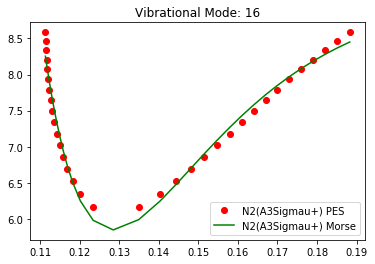

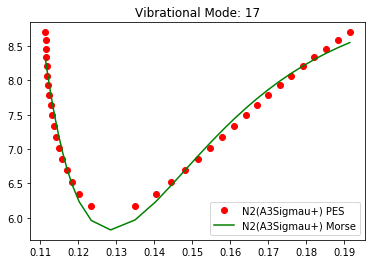

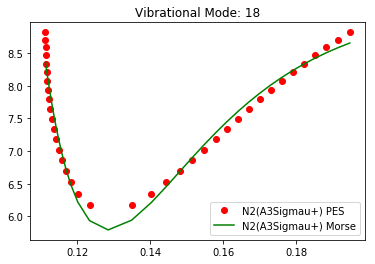

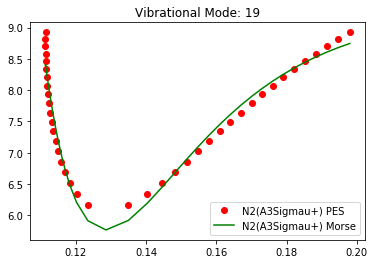

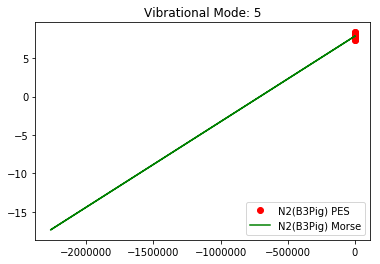

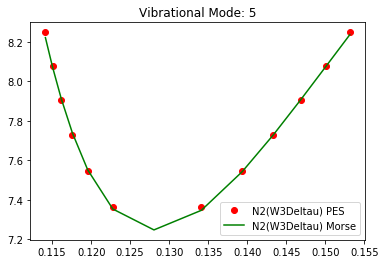

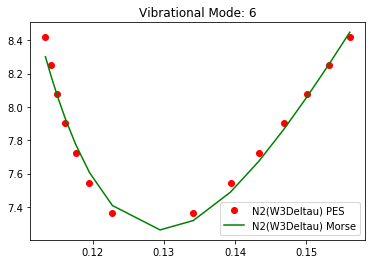

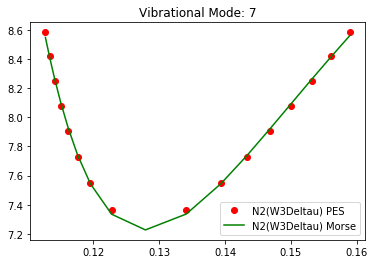

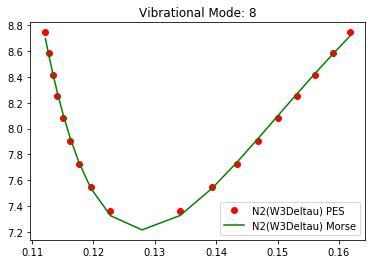

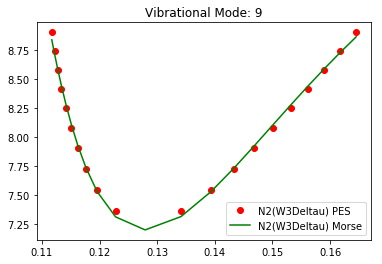

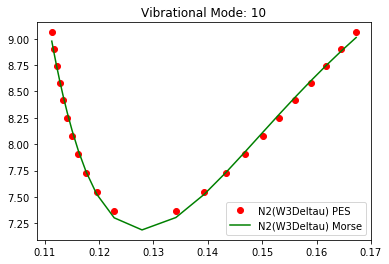

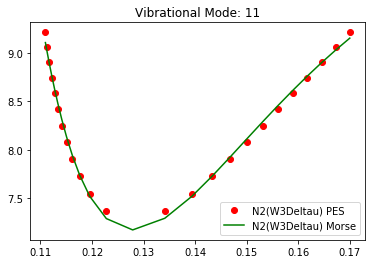

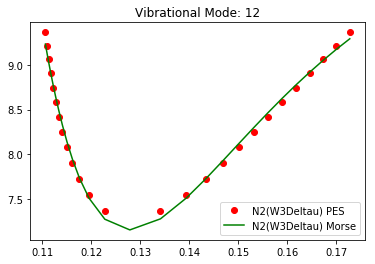

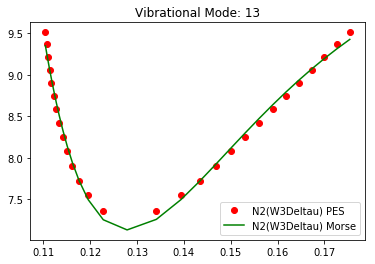

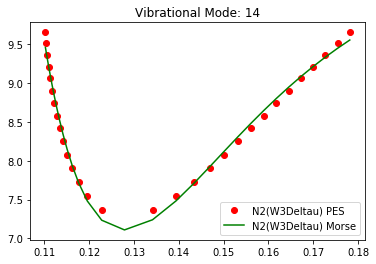

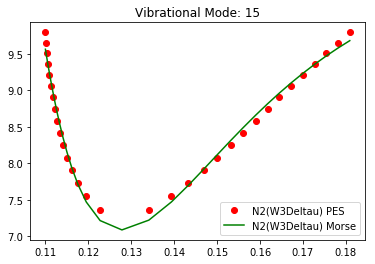

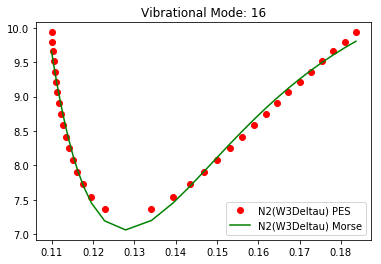

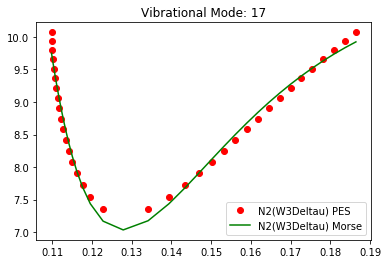

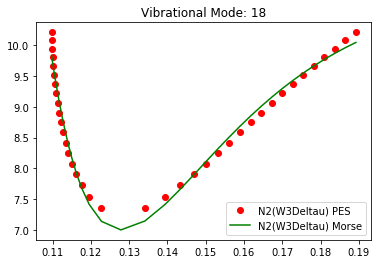

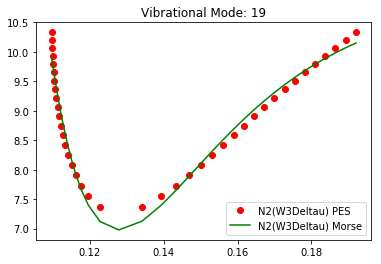

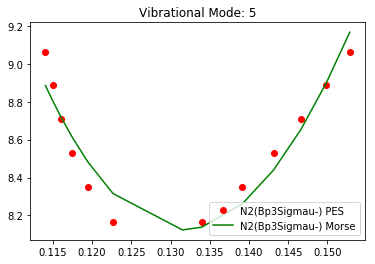

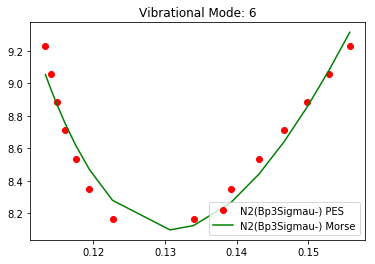

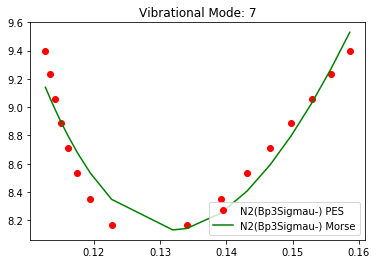

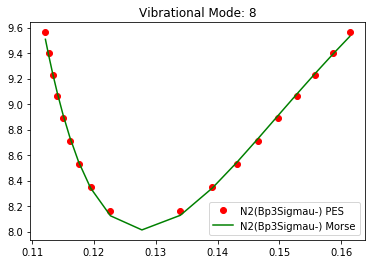

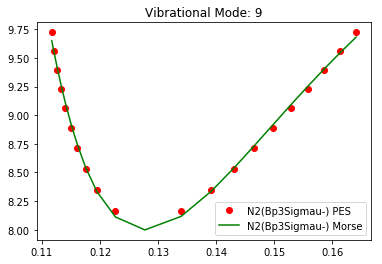

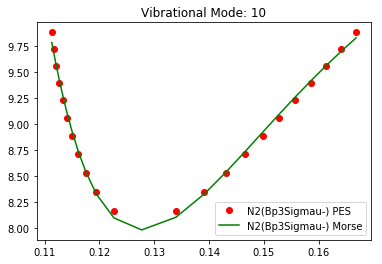

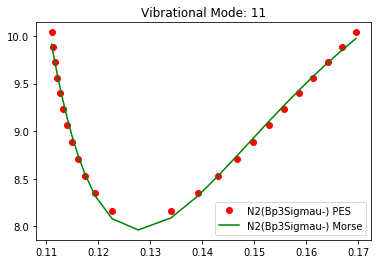

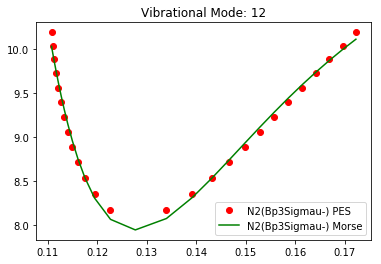

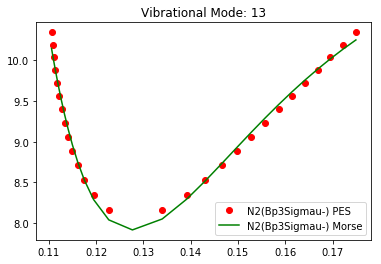

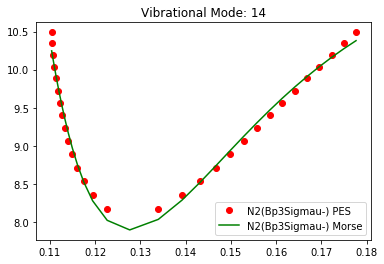

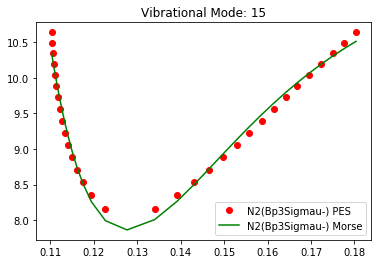

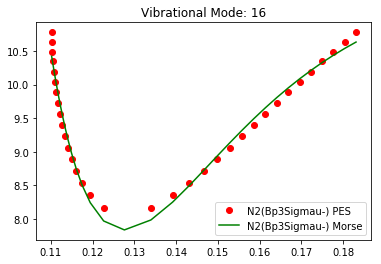

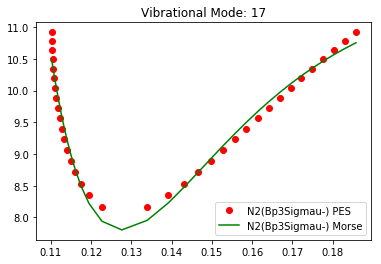

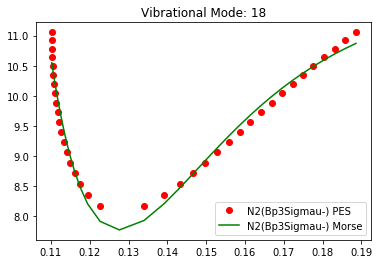

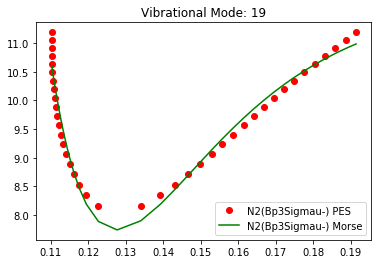

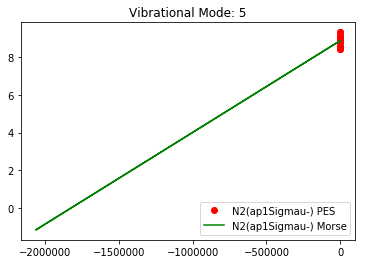

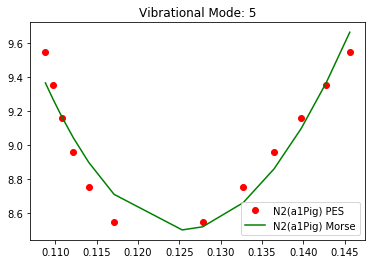

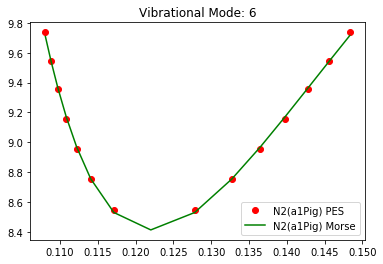

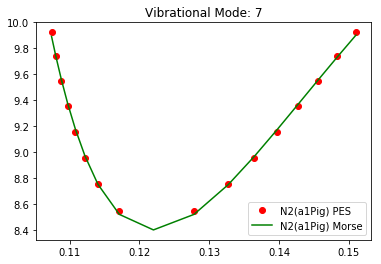

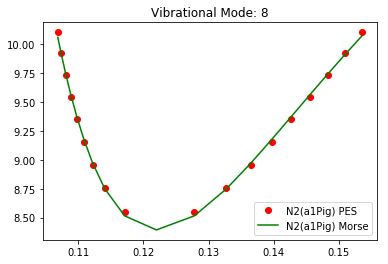

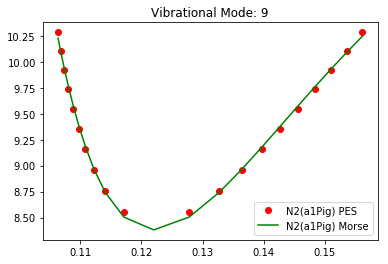

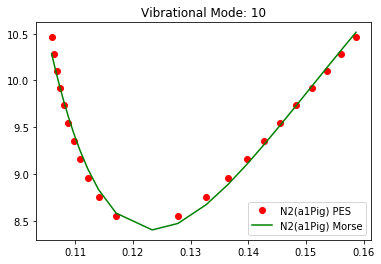

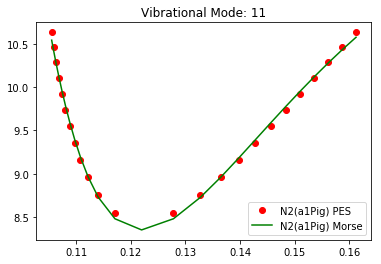

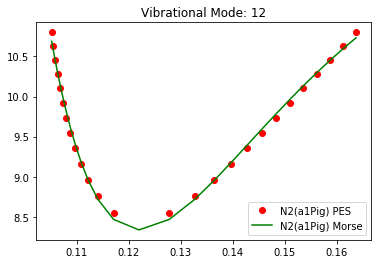

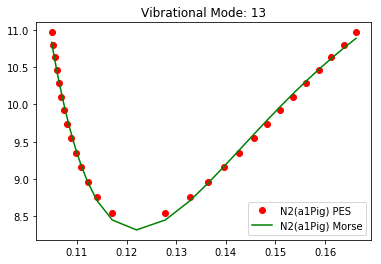

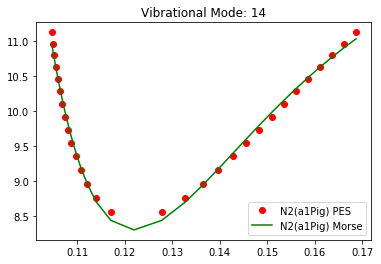

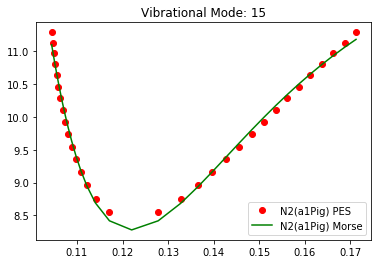

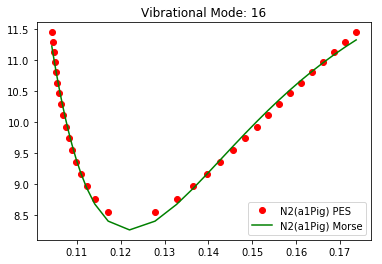

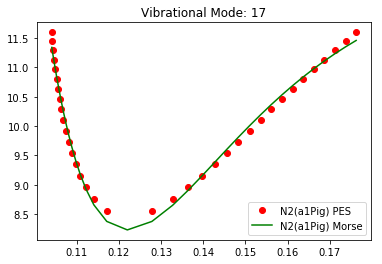

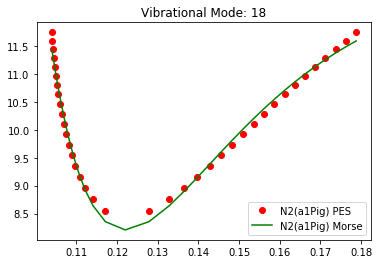

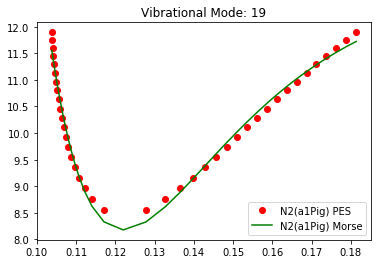

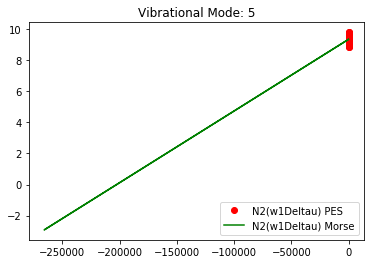

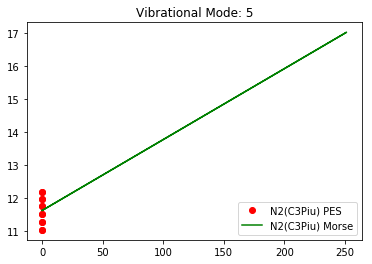

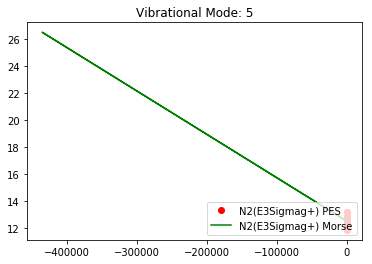

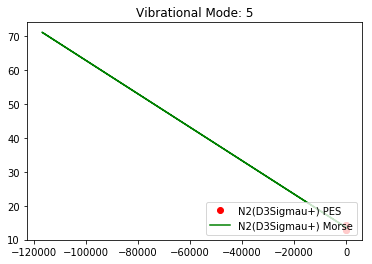

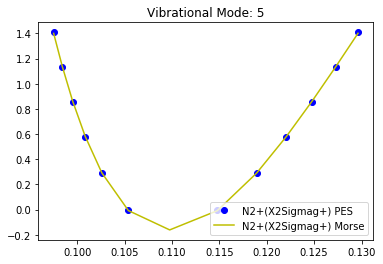

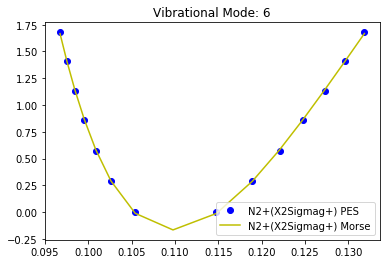

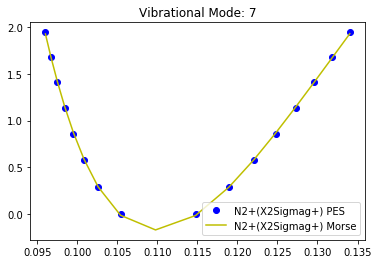

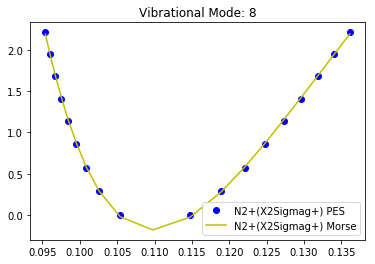

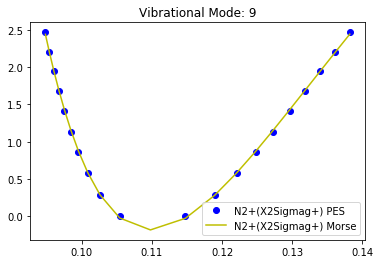

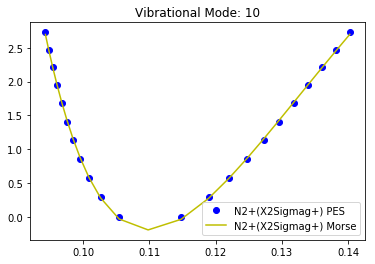

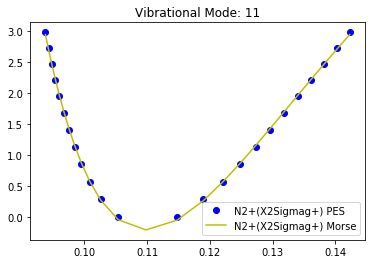

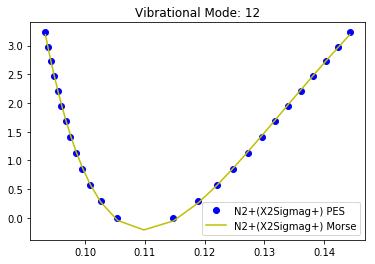

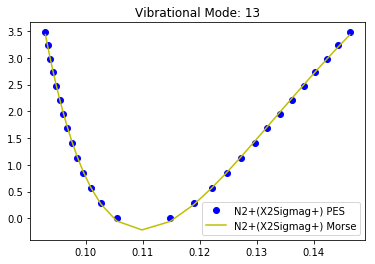

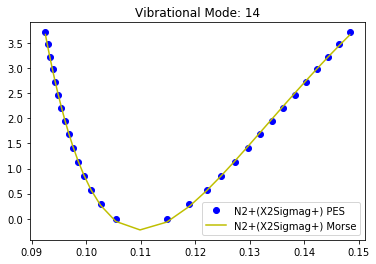

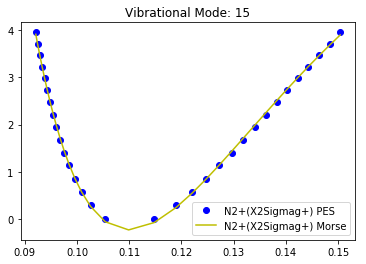

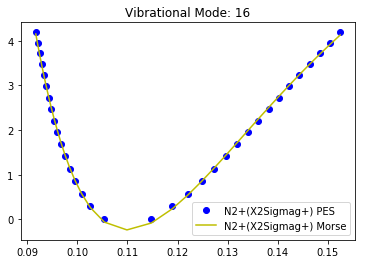

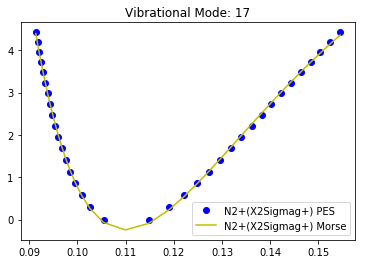

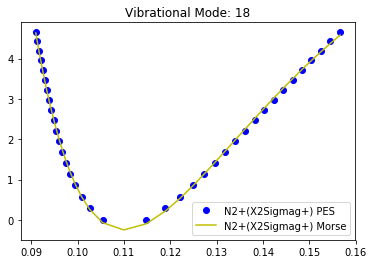

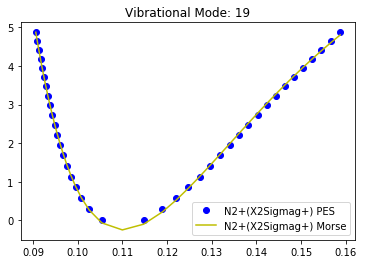

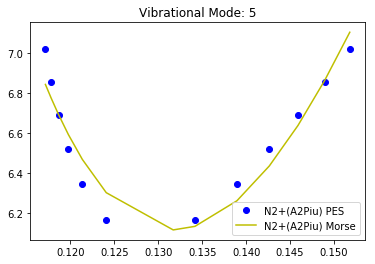

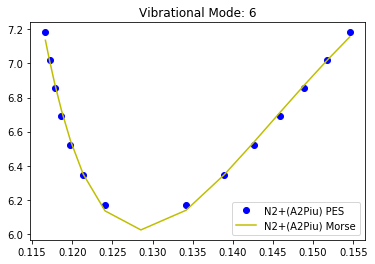

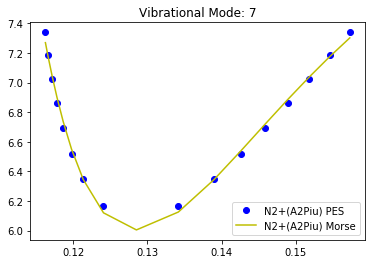

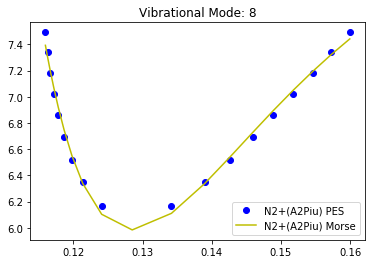

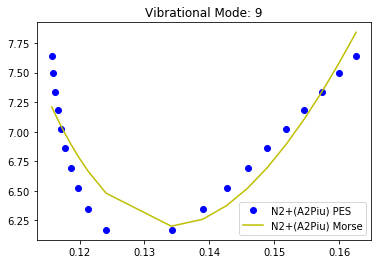

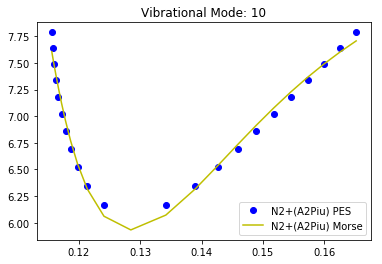

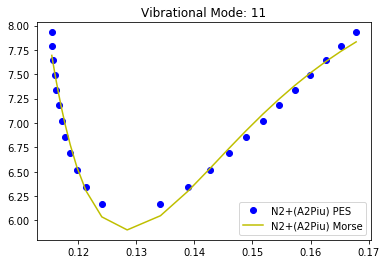

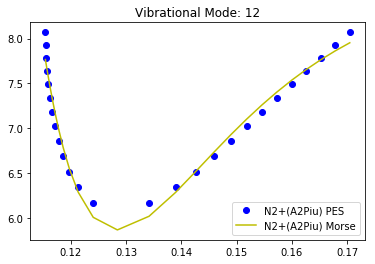

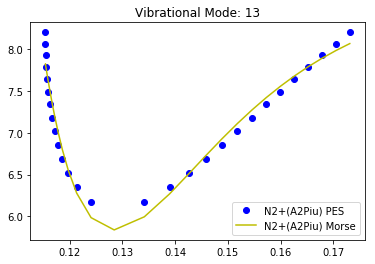

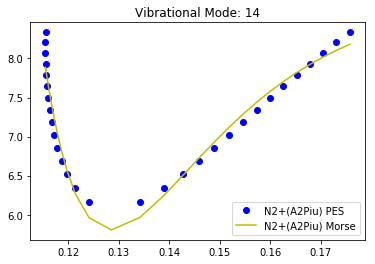

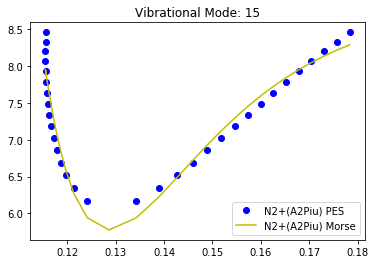

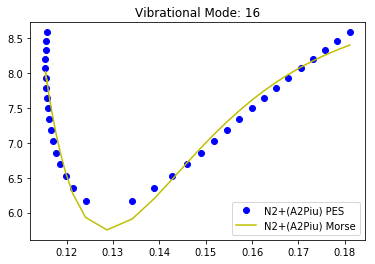

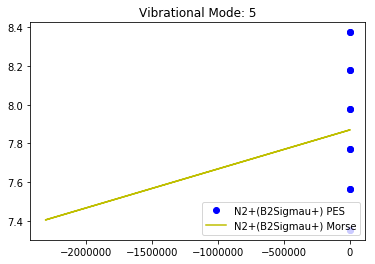

In [69]:
#TODO: Add a dictionary for all of the constants for the different fits
#TODO: Plot the highest v_max's for all of the states onto one plot

# the number of vibrational modes
vibrational_mode = np.arange(5, 20)

# the number of states in N2
num_N2_states = np.arange(0, 11)
# the number of states in N2+
num_N2p_states= np.arange(0, 3)

# dictionary for the mean square errors of the different vibrational modes of the states
msqe_states_N2 = {}
msqe_states_N2p = {}

# dictionary for the constants we'll get from the fit
fit_constants_states_N2 = {}
fit_constants_states_N2p = {}

for ii in num_N2_states:
    # creates/clears the dictionary at each new state
    msqe_vib = {}
    
    for i in vibrational_mode:
    
        state_pes = compute_pes(ii, vib_constants_N2, rot_constants_N2, vmax=i)

        # optimize has a hard time doing the fit with a square in the function. You have to decompose it. 
        # Also, you have to give it a constant (p[2]) for the minimum energy when r=r_e.
        # Target function
        fitfunc = lambda p, x: p[0] * (1.0 - np.exp(-p[1] * (x - p[2]))) * (1.0 - np.exp(-p[1] * (x - p[2]))) + p[3]
        errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

        # p[0]=De, p[1]=Beta, p[2]=re, p[3]=D0 
        p0_0 = [10.0, 0.001, 0.11, -1.0] # Initial guess for the parameters
        p0_1, success0 = optimize.leastsq(errfunc, p0_0[:], args=(state_pes[:,0], state_pes[:,1]))
    
        # constants taken from the fit: De, Beta, re, D0
        fit_constants_states_N2[i] = [p0_1[0], p0_1[1], p0_1[2], p0_1[3]]
    
        # Plotting the functions
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
    
        # plotting X1Sigmagp
        x,y = state_pes.T
        x_fit = np.insert(x, i+1, p0_1[2])
        y_fit_nore = fitfunc(p0_1, x)
        y_fit = fitfunc(p0_1, x_fit)

        # Plot of the data and the fit
        plt.plot(x, y, "ro", label = '%s PES' % states_N2[ii])
        plt.plot(x_fit, y_fit, "g-", label = '%s Morse' % states_N2[ii])
    
        # extra plot things
        plt.title('Vibrational Mode: %s' % i)
        plt.legend(loc='lower right');
        plt.show()

        # calculating the mean square error of between the PES and the fit 
        msqe_vib_cal = (np.square(state_pes.T[1] - y_fit_nore)).mean()
        msqe_vib[i] = msqe_vib_cal
        if msqe_vib_cal > 0.05:
            break
    
    # placing the most recent state vibrational msqe into the dictionary
    msqe_states_N2[states_N2[ii]] = msqe_vib

# modifying the state for the N2+
for ii in num_N2p_states:
    # creates/clears the dictionary at each new state
    msqe_vib = {}
    
    for i in vibrational_mode:
    
        state_pes = compute_pes(ii, vib_constants_N2p, rot_constants_N2p, vmax=i)

        # optimize has a hard time doing the fit with a square in the function. You have to decompose it. 
        # Also, you have to give it a constant (p[2]) for the minimum energy when r=r_e.
        # Target function
        fitfunc = lambda p, x: p[0] * (1.0 - np.exp(-p[1] * (x - p[2]))) * (1.0 - np.exp(-p[1] * (x - p[2]))) + p[3]
        errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

        # p[0]=De, p[1]=Beta, p[2]=re, p[3]=D0 
        p0_0 = [10.0, 0.001, 0.11, -1.0] # Initial guess for the parameters
        p0_1, success0 = optimize.leastsq(errfunc, p0_0[:], args=(state_pes[:,0], state_pes[:,1]))
    
        # constants taken from the fit: De, Beta, re, D0
        fit_constants_states_N2p[i] = [p0_1[0], p0_1[1], p0_1[2], p0_1[3]]
    
        # Plotting the functions
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
    
        # plotting X1Sigmagp
        x,y = state_pes.T
        x_fit = np.insert(x, i+1, p0_1[2])
        y_fit_nore = fitfunc(p0_1, x)
        y_fit = fitfunc(p0_1, x_fit)

        # Plot of the data and the fit
        plt.plot(x, y, "bo", label = '%s PES' % states_N2p[ii])
        plt.plot(x_fit, y_fit, "y-", label = '%s Morse' % states_N2p[ii])
    
        # extra plot things
        plt.title('Vibrational Mode: %s' % i)
        plt.legend(loc='lower right');
        plt.show()

        # calculating the mean square error of between the PES and the fit 
        msqe_vib_cal = (np.square(state_pes.T[1] - y_fit_nore)).mean()
        msqe_vib[i] = msqe_vib_cal
        if msqe_vib_cal > 0.05:
            break
    
    # placing the most recent state vibrational msqe into the dictionary
    msqe_states_N2p[states_N2p[ii]] = msqe_vib


In [66]:
msqe_states_N2

{'N2(X1Sigmag+)': {5: 8.356430263235348e-05,
  6: 0.0001615065939076285,
  7: 0.0002831130715410853,
  8: 0.00046191615896332697,
  9: 0.0007131324104656572,
  10: 0.0010535680852495233,
  11: 0.0015014962407362779,
  12: 0.0020765020199932874,
  13: 0.0027992926894319617,
  14: 0.0036914689195911136,
  15: 0.0047752538096541616,
  16: 0.006073176263837348,
  17: 0.007607705548241815,
  18: 0.009400834233846734,
  19: 0.011473607293405953},
 'N2(A3Sigmau+)': {5: 0.00045559632043629095,
  6: 0.00023485053497044602,
  7: 0.0004301556962579739,
  8: 0.0007342645396476391,
  9: 0.001187547897600903,
  10: 0.0018403948952245815,
  11: 0.0027550052754371644,
  12: 0.004007434436459506,
  13: 0.005689892886501665,
  14: 0.00791327627931183,
  15: 0.010809858443534399,
  16: 0.01453600873562329,
  17: 0.01927468529113267,
  18: 0.025237294782959375,
  19: 0.03266428737574123},
 'N2(B3Pig)': {5: 0.12168174939057037},
 'N2(W3Deltau)': {5: 0.00012664261183126536,
  6: 0.0026341119500785256,
  7: 

In [70]:
msqe_states_N2p

{'N2+(X2Sigmag+)': {5: 4.105599893100602e-05,
  6: 7.612876321442628e-05,
  7: 0.0001273686605924257,
  8: 0.0001972029281536315,
  9: 0.0002870804417206695,
  10: 0.0003971140840733195,
  11: 0.0005257759169823478,
  12: 0.0006696973025025963,
  13: 0.0008236433638691686,
  14: 0.0009807523455597864,
  15: 0.0011331561384246565,
  16: 0.001273129212968886,
  17: 0.0013949500368637471,
  18: 0.0014977024370514444,
  19: 0.0015892947417648876},
 'N2+(A2Piu)': {5: 0.008493550429452544,
  6: 0.0006043701634566978,
  7: 0.0011399523352850788,
  8: 0.0020072600373659847,
  9: 0.040580200912839044,
  10: 0.005381492714866695,
  11: 0.008352457443374475,
  12: 0.012614430025127358,
  13: 0.018614458743425905,
  14: 0.026915470593620254,
  15: 0.03820270559283487,
  16: 0.05326899923222654},
 'N2+(B2Sigmau+)': {5: 0.12168174939056299}}